In [42]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from farmsize import data_prep, db_scan, mapping
from shapely.geometry import Point
import re


In [120]:
base_path = "./data/ipums/raw/"
base_shape_file_string = "boundaries_15086_IPUMS"
data_sets = ["BF_SLAD_2006","ET_SLAD_2007","GH_SLAD_2010","KE_SLAD_2009","ML_SLAD_2009","NG_SLAD_2010","RW_SLAD_2012","TZ_SLAD_2012","UG_SLAD_2002"]

iso_2 = [string[0:2] for string in data_sets]
year =  [string[-4:] for string in data_sets]
id =  [string[0:2]+string[-4:] for string in data_sets]



for index in range(0,len(data_sets)):
    df_path = base_path + "csvs/data_15086_IPUMS_" + data_sets[index] + ".csv"
    shape_file_path = base_path + "shapefiles/boundaries_15086_IPUMS_" + data_sets[index] + ".shp" 

    new_data_set = pd.read_csv(df_path)
    new_data_set.columns = [re.sub(id[index],"", string) for string in new_data_set.columns]
    new_data_set.columns=[re.sub("__","", string) for string in new_data_set.columns]
    new_data_set.columns = [string.rstrip("_") for string in new_data_set.columns]
    new_data_set["iso_2"] = iso_2[index]
    new_data_set["year"] = year[index]
    new_data_set["id"]=id[index]

    new_shape_file = gpd.read_file(shape_file_path)
    new_shape_file["GEOID"]=new_shape_file["GEOID"].astype("int64")

    new_data_set = new_shape_file.merge(new_data_set, left_on="GEOID", right_on="GEO2")

    if index==0:
        ipums_terra_data = new_data_set
    if index>0:
        ipums_terra_data = ipums_terra_data.append(new_data_set)

#re.sub("_SLAD_", "", string)


In [115]:
new_shape_file["GEOID"].astype("int64")

0      213001
1      213002
2      212004
3      212001
4      212002
        ...  
156    113003
157    112001
158    112002
159    111002
160    111001
Name: GEOID, Length: 161, dtype: int64

In [ ]:

column_headers <- gsub("_SLAD_", "", data_sets)
countries <- substr(data_sets,0,2)
years <- substr(data_sets,9,12)


file_paths <- paste0(base_path,base_data_string,"_",data_sets,".csv")

index <- 1



for (file_path in file_paths){
  if (index==1){
    ipums_terra_df <- readr::read_csv(file_path)
    ipums_terra_df$iso_2 <- countries[index]
    ipums_terra_df$year <- years[index]
    ipums_terra_df$ipums_code <- data_sets[index]
    colnames(ipums_terra_df) <- gsub(column_headers[index],"",colnames(ipums_terra_df)) %>% 
      gsub("__","",.) %>% 
      gsub("_$","",.)
    
  }
  
  if (index>1){
    new_df <- readr::read_csv(file_path)
    new_df$iso_2 <- countries[index]
    new_df$year <- years[index]
    new_df$ipums_code <- data_sets[index]
    colnames(new_df) <- gsub(column_headers[index],"",colnames(new_df)) %>% 
      gsub("__","",.) %>% 
      gsub("_$","",.)
    ipums_terra_df <- dplyr::bind_rows(ipums_terra_df, new_df)
  }
  
  index <- index + 1
  
}


readr::write_csv(ipums_terra_df,"./data/processed/aggregated/ipums_terra.csv")









In [3]:
ipums_terra = pd.read_csv("./data/ipums/ipums_terra.csv")
ipums_terra

,GEO2LABEL,GEO2,EDUCTERTIARY_GEO2A,EDUCSECOND_GEO2A,EDUCPRIMARY_GEO2A,EDUCLESSPRIM_GEO2A,SCHOOL0617_GEO2A,SCHOOL1015_GEO2A,SCHOOL0609_GEO2A,LABORAGRIC_GEO2A,...,IGBP_CROPLAND_percent_area_bin_GEO2IGBP_2012_2012,IGBP_MXDFRST_percent_area_bin_GEO2IGBP_2012_2012,IGBP_BARREN_percent_area_bin_GEO2IGBP_2012_2012,IGBP_WATER_percent_area_bin_GEO2IGBP_2012_2012,IGBP_URBAN_percent_area_bin_GEO2IGBP_2012_2012,IGBP_num_classes_GEO2IGBP_2012_2012,IGBP_mode_GEO2IGBP_2012_2012,iso_2,year,ipums_code
0,Sourou,1027,0.212596,1.275578,5.753388,91.868190,33.664964,34.168366,38.434505,NaN,...,5.276687,NaN,NaN,NaN,0.046412,9.0,14.0,BF,2006,BF_SLAD_2006
1,Leraba,2038,0.321942,1.461119,5.299653,91.976226,28.321033,27.508915,32.439978,NaN,...,2.247749,NaN,0.014181,0.014181,NaN,12.0,14.0,BF,2006,BF_SLAD_2006
2,Yagha,12043,0.093301,0.597126,1.492816,94.551222,14.848012,16.297872,17.058824,NaN,...,0.606880,NaN,0.982882,NaN,NaN,5.0,10.0,BF,2006,BF_SLAD_2006
3,Ioba,13033,0.361061,1.527566,7.068463,89.265380,29.797895,30.696318,33.521354,NaN,...,5.113710,NaN,NaN,NaN,NaN,8.0,14.0,BF,2006,BF_SLAD_2006
4,Passore,10020,0.321630,1.241848,4.288395,92.763334,38.767077,39.975093,43.026455,NaN,...,8.108108,NaN,0.188061,0.069851,0.112836,11.0,14.0,BF,2006,BF_SLAD_2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,West Moyo,309002,0.767334,9.728693,40.750891,59.249109,87.039017,94.964423,78.033022,56.973059,...,2.171137,NaN,NaN,NaN,0.510856,8.0,8.0,UG,2002,UG_SLAD_2002
1648,Samia-Bugwe,202001,0.370421,5.885581,41.843874,58.156126,87.209620,92.596779,87.376587,69.091616,...,25.020781,0.083126,0.027709,2.826268,0.083126,10.0,14.0,UG,2002,UG_SLAD_2002
1649,Obongi,309001,0.146466,5.602343,37.532040,62.467960,88.683680,92.912281,84.621779,83.703234,...,1.754826,0.100276,NaN,0.325896,NaN,9.0,9.0,UG,2002,UG_SLAD_2002
1650,Kinkiizi,414001,0.167072,4.419806,32.700486,67.299514,83.455986,89.488556,80.858469,86.184812,...,1.939103,0.032051,NaN,5.528846,0.336538,11.0,14.0,UG,2002,UG_SLAD_2002


In [4]:
country_mapping = data_prep.load_json("./data/country_mappings.json")

# Loading the administrative data
# ipums_level1 = gpd.read_file('./data/mapping/ipums/world_geolev1_2020/world_geolev1_2020.shp')
ipums_level2 = gpd.read_file('./data/mapping/ipums/world_geolev2_2020/world_geolev2_2020.shp')

# Subsetting it to match the countries 
# ipums_level1 = ipums_level1.loc[ipums_level1["CNTRY_NAME"].isin(country_mapping["ipums"]),:]
ipums_level2 = ipums_level2.loc[ipums_level2["CNTRY_NAME"].isin(country_mapping["ipums"]),:]

# Adding ISO country details
# ipums_level1 = ipums_level1.merge(country_mapping, left_on="CNTRY_NAME", right_on="ipums", how="left")
ipums_level2 = ipums_level2.merge(country_mapping, left_on="CNTRY_NAME", right_on="ipums", how="left")

# Loading RHoMIS Indicators
indicator_data = pd.read_csv("./data/RHoMIS_Indicators.csv", encoding="latin")
countries_iso_2 = country_mapping["iso_2"].to_list()
indicator_data = data_prep.subset_data(indicator_data, complete_gps=True, countries=countries_iso_2) # Subsetting data bas

In [36]:
ipums_terra


,GEO2LABEL,GEO2,EDUCTERTIARY_GEO2A,EDUCSECOND_GEO2A,EDUCPRIMARY_GEO2A,EDUCLESSPRIM_GEO2A,SCHOOL0617_GEO2A,SCHOOL1015_GEO2A,SCHOOL0609_GEO2A,LABORAGRIC_GEO2A,...,IGBP_CROPLAND_percent_area_bin_GEO2IGBP_2012_2012,IGBP_MXDFRST_percent_area_bin_GEO2IGBP_2012_2012,IGBP_BARREN_percent_area_bin_GEO2IGBP_2012_2012,IGBP_WATER_percent_area_bin_GEO2IGBP_2012_2012,IGBP_URBAN_percent_area_bin_GEO2IGBP_2012_2012,IGBP_num_classes_GEO2IGBP_2012_2012,IGBP_mode_GEO2IGBP_2012_2012,iso_2,year,ipums_code
0,Sourou,1027,0.212596,1.275578,5.753388,91.868190,33.664964,34.168366,38.434505,NaN,...,5.276687,NaN,NaN,NaN,0.046412,9.0,14.0,BF,2006,BF_SLAD_2006
1,Leraba,2038,0.321942,1.461119,5.299653,91.976226,28.321033,27.508915,32.439978,NaN,...,2.247749,NaN,0.014181,0.014181,NaN,12.0,14.0,BF,2006,BF_SLAD_2006
2,Yagha,12043,0.093301,0.597126,1.492816,94.551222,14.848012,16.297872,17.058824,NaN,...,0.606880,NaN,0.982882,NaN,NaN,5.0,10.0,BF,2006,BF_SLAD_2006
3,Ioba,13033,0.361061,1.527566,7.068463,89.265380,29.797895,30.696318,33.521354,NaN,...,5.113710,NaN,NaN,NaN,NaN,8.0,14.0,BF,2006,BF_SLAD_2006
4,Passore,10020,0.321630,1.241848,4.288395,92.763334,38.767077,39.975093,43.026455,NaN,...,8.108108,NaN,0.188061,0.069851,0.112836,11.0,14.0,BF,2006,BF_SLAD_2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,West Moyo,309002,0.767334,9.728693,40.750891,59.249109,87.039017,94.964423,78.033022,56.973059,...,2.171137,NaN,NaN,NaN,0.510856,8.0,8.0,UG,2002,UG_SLAD_2002
1648,Samia-Bugwe,202001,0.370421,5.885581,41.843874,58.156126,87.209620,92.596779,87.376587,69.091616,...,25.020781,0.083126,0.027709,2.826268,0.083126,10.0,14.0,UG,2002,UG_SLAD_2002
1649,Obongi,309001,0.146466,5.602343,37.532040,62.467960,88.683680,92.912281,84.621779,83.703234,...,1.754826,0.100276,NaN,0.325896,NaN,9.0,9.0,UG,2002,UG_SLAD_2002
1650,Kinkiizi,414001,0.167072,4.419806,32.700486,67.299514,83.455986,89.488556,80.858469,86.184812,...,1.939103,0.032051,NaN,5.528846,0.336538,11.0,14.0,UG,2002,UG_SLAD_2002


<AxesSubplot:>

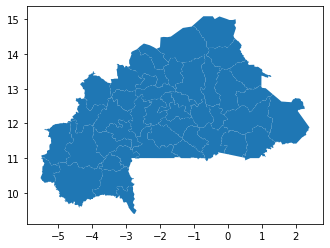

In [40]:
ipums_terra_shape = gpd.read_file("./data/ipums/shapefiles/boundaries_15086_IPUMS_BF_SLAD_2006.shp")
ipums_terra_shape["GEOID"]= ipums_terra_shape["GEOID"].astype("int64")
ipums_terra_shape.plot()

In [28]:
ipums_terra["GEO2"].unique()
#ipums_level2

array([  1027,   2038,  12043, ..., 309001, 414001, 301001])

In [ ]:
# World Shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

In [ ]:
# Generated using the function adminstrative_boundaries = mapping.get_admin_boundaries_multiple_countries(...)
admin_1 = mapping.read_admin_boundaries_file('./data/mapping/subnational_geometries.csv')
admin_1

In [ ]:
# Spatially joining the two datasets
indicator_data["geometry"] = [Point(xy) for xy in zip(indicator_data["GPS_LON"], indicator_data["GPS_LAT"])]
geo_indicator = gpd.GeoDataFrame(indicator_data)
geo_indicator = geo_indicator.sjoin(world, how="left", op="within")


In [ ]:
# Plot the points on a map
#same as
#fig= plt.figure()
#ax=fig.add_subplot()
fig, ax =  plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
#Plot map layer
world.loc[world["continent"]=="Africa",].plot(ax=ax,color="white", edgecolor="black")

world.loc[world["iso_a3"].isin(countries_iso_3),].plot(ax=ax,color="blue", edgecolor="black", alpha=0.1)

#Plot Points
geo_indicator.plot(ax=ax, marker=0, color='black', markersize=5)

fig.show()
fig.savefig('./outputs/exploratory/map.png')


In [ ]:
# Grouping by 
row_subsets = indicator_data["LandCultivated"].notna() & indicator_data["LandCultivated"].between(0.05,100)
column_subsets= ["ID_COUNTRY", "LandCultivated"]
grouping="ID_COUNTRY"

fig, ax = plt.subplots(figsize=(10,10))
plt.tight_layout()
ax.set_title("KDE of Land ")
ax.set_xlabel("Land Cultivated (ha)")
ax.set_ylabel("Density")
ax.set_xlim([0,25])
ax.set_ylim([0,0.6])
indicator_data.loc[row_subsets,:].groupby("ID_COUNTRY")["LandCultivated"].plot(kind="kde", ax=ax, legend=True)
fig.savefig("./outputs/exploratory/land_size_kde_all_countries.png", bbox_inches="tight")

# Clustering Households Spatially

In [ ]:
cluster_labels = db_scan.cluster_gps_points(indicator_data, "GPS_LON", "GPS_LAT", epsilon=0.1)